In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient
import yaml
import ssl

red_color_schema = "#cc1228"
green_color_schema = "#3c8c30"

In [2]:
def yaml_loader(config_path):
    with open(config_path) as f:
        return yaml.load(f)
    
config=yaml_loader("../server/config.yaml")

In [32]:
mongo_uri = config.get("mongo_uri").format(config.get("mongo_username"), config.get("mongo_password"))
db = MongoClient(mongo_uri,ssl=True,ssl_cert_reqs=ssl.CERT_NONE)
coll = db.bitcoin.orders
# GET max and min prices.
result = coll.aggregate([{"$group": {"_id": None, "maxPrice": {"$max": "$price"}, "minPrice": {"$min": "$price"}
                                     }}])
data = result.next()
print(data)
max_price = int(data["maxPrice"]/100+1)*100 #6600
min_price = int(data["minPrice"]/100)*100  #6200

# print(y)

result = coll.find({})
datas = []
for data in result:
    datas.append(data)

{'_id': None, 'maxPrice': 6554.4, 'minPrice': 6202.8}


[6200. 6210. 6220. 6230. 6240. 6250. 6260. 6270. 6280. 6290. 6300. 6310.
 6320. 6330. 6340. 6350. 6360. 6370. 6380. 6390. 6400. 6410. 6420. 6430.
 6440. 6450. 6460. 6470. 6480. 6490. 6500. 6510. 6520. 6530. 6540. 6550.
 6560. 6570. 6580. 6590. 6600.]
41.0
[142.8739584  177.63996722 329.47959353 209.06607198 221.4473262
 471.22443086 256.73288955 335.90894015  85.33972159  67.52565471
 400.00866057  41.32029036  54.39552766 106.52128924 212.29167137
 117.13210695 102.65349797 108.49965314  30.14131148  94.93881988
  39.82277394 188.8988521  202.211623   534.72150171 347.64784719
 303.27320018 180.06979213 272.01771509 172.93999443 165.3046979
 379.58812079 283.58525182 304.07087733 310.90363554 164.26690135
  51.80619016   0.           0.           0.           0.
   0.        ]
[-142.8739584  -156.1795684  -181.35838347   -5.48433892    1.31397908
 -168.24603572  -67.17490559 -117.63541897  -12.36676881  -26.41360329
  182.37023611  -17.37429036   -8.59552766    6.85448854  -77.6509615

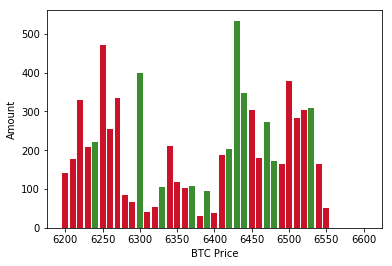

In [38]:
x = np.linspace(min_price,max_price,(max_price-min_price)//10+1)
print(x)
print((max_price-min_price)/10+1)
y = np.zeros(int((max_price-min_price)/10+1))
y2 = np.zeros(int((max_price-min_price)/10+1))


for data in datas:
        y[int((data["price"]-min_price)//10)]+=abs(data["amount"])
        y2[int((data["price"]-min_price)//10)]+=data["amount"]
print(y)
print(y2)
# print(x.shape)
for i in range(0,x.shape[0]):
    if y2[i]<0:
        y2[i]=int(y[i])
        y[i] = 0
    else:
        y[i] = int(y[i])
        y2[i]=0
print(y)
print(y2)
print("BTC Whales orders:")
plt.xlabel('BTC Price')
plt.ylabel('Amount')

plt.bar(x, y,color=green_color_schema,width=8)
plt.bar(x,y2,color=red_color_schema,width=8)
plt.show()

[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
 222.21547851   0.           0.           0.          47.57697091
   0.           0.          61.1875       0.           0.
   0.           0.           0.         299.38199447 219.7352289
   0.           0.          60.68168732  36.38472928   0.
   0.           0.           0.         205.00600849   0.
   0.           0.           0.           0.           0.
   0.        ]
[136.73795427 129.          91.673992    20.           0.
 107.18140512 136.6924451  115.05716826   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.          20.82721167  45.72752879   0.           0.
  86.27285979  20.83694561   0.           0.          51.41057769
 139.28469606 126.41296092 198.61337846   0.         111.4947215
  37.44138385   0.           0.           0.           0.
   0.        ]
BTC Whales o

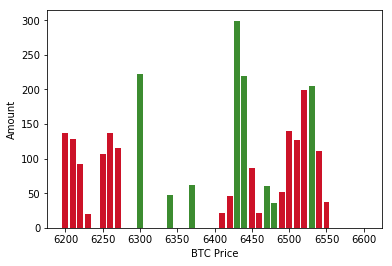

In [44]:
# Set a threshold for small orders.

y = np.zeros(int((max_price-min_price)/10+1))
y2 = np.zeros(int((max_price-min_price)/10+1))
threshold=20

for data in datas:
    if abs(data["amount"])>=threshold:
        y[int((data["price"]-min_price)//10)]+=abs(data["amount"])
        y2[int((data["price"]-min_price)//10)]+=data["amount"]

for i in range(0,x.shape[0]):
    if y2[i]<0:
        y2[i]=y[i]
        y[i] = 0
    else:
        y2[i]=0
print(y)
print(y2)
print("BTC Whales orders larger than 20:")


plt.xlabel('BTC Price')
plt.ylabel('Amount')

plt.bar(x, y, color=green_color_schema,width=8)
plt.bar(x,y2,color=red_color_schema,width=8)
plt.show()

In [45]:
def draw_volume(collection, start_time, end_time, filter_func=None, *, title=""):
    result = coll.find({"time": {"$lt": end_time,"$gt":start_time}})
    
    result = list(result)
    
    max_price = int(max(result, key=lambda x: x["price"])["price"])
    min_price = int(min(result, key=lambda x: x["price"])["price"])
    
    x = np.linspace(min_price,max_price,(max_price-min_price)//10+1)
    y = np.zeros(int((max_price-min_price)/10+1))
    y2 = np.zeros(int((max_price-min_price)/10+1))


    for data in result:
        if not filter_func or filter_func(data):
            y[int((data["price"]-min_price)//10)]+=abs(data["amount"])
            y2[int((data["price"]-min_price)//10)]+=data["amount"]
        
    for i in range(0,x.shape[0]):
        if y2[i]<0:
            y2[i]=y[i]
            y[i] = 0
        else:
            y2[i]=0
            
    plt.title(title)
    plt.xlabel('BTC Price')
    plt.ylabel('Amount')

    plt.bar(x, y, color=green_color_schema,width=8)
    plt.bar(x,y2,color=red_color_schema,width=8)
    plt.show()

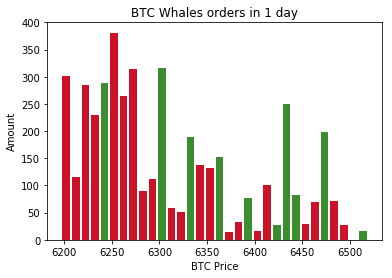

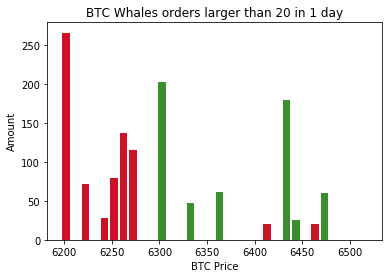

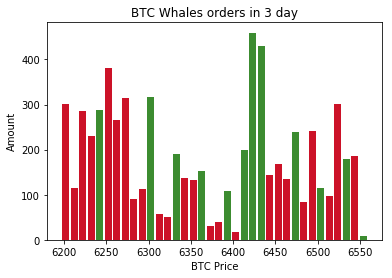

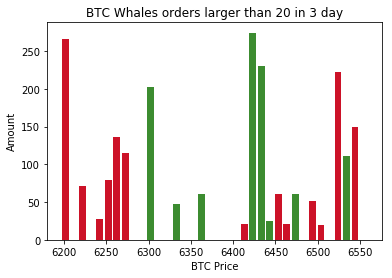

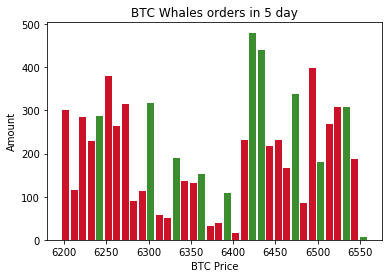

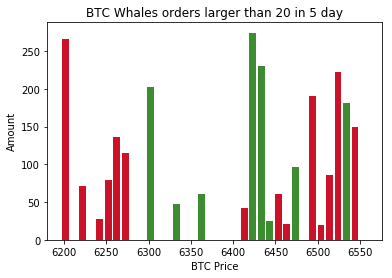

In [46]:
import time 

mongo_uri = config.get("mongo_uri").format(config.get("mongo_username"), config.get("mongo_password"))
db = MongoClient(mongo_uri,ssl=True,ssl_cert_reqs=ssl.CERT_NONE)
coll = db.bitcoin.orders

draw_volume(coll, int((time.time()-24*3600)*1000), int(time.time()*1000), title="BTC Whales orders in 1 day")
draw_volume(coll, int((time.time()-24*3600)*1000), int(time.time()*1000), lambda x: abs(x["amount"]) > 20, title="BTC Whales orders larger than 20 in 1 day")

draw_volume(coll, int((time.time()-3*24*3600)*1000), int(time.time()*1000), title="BTC Whales orders in 3 day")
draw_volume(coll, int((time.time()-3*24*3600)*1000), int(time.time()*1000), lambda x: abs(x["amount"]) > 20, title="BTC Whales orders larger than 20 in 3 day")

draw_volume(coll, int((time.time()-5*24*3600)*1000), int(time.time()*1000), title="BTC Whales orders in 5 day")
draw_volume(coll, int((time.time()-5*24*3600)*1000), int(time.time()*1000), lambda x: abs(x["amount"]) > 20, title="BTC Whales orders larger than 20 in 5 day")

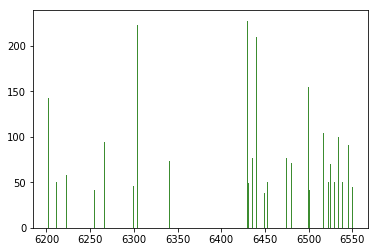

In [49]:
mongo_uri = config.get("mongo_uri").format(config.get("mongo_username"), config.get("mongo_password"))
db = MongoClient(mongo_uri,ssl=True,ssl_cert_reqs=ssl.CERT_NONE)
coll = db.bitcoin.orders
# GET max and min prices.
result = coll.aggregate([{"$group": {"_id": "$price", "orders": {"$push" : "$amount"}
                                     }}])
lists = []
for data in result:
    data['total'] = sum([abs(i) for i in data['orders']])
    data['direction'] = sum([i for i in data['orders']])

    lists.append(data)

datas=sorted(lists,key=lambda lists: lists['total'],reverse = True)
x = np.array([i['_id'] for i in datas[:30]])
y = np.array([i['total'] for i in datas[:30]])

plt.bar(x, y, color=green_color_schema,width=1)
plt.show()





In [ ]:
import datetime
import random
import matplotlib.dates as mdates


def draw_time_series_orders(collection, start_time, end_time,period, filter_func=None, *, title=""):
    def convert_to_datetime64(timestamp):
        dt= datetime.datetime.utcfromtimestamp(timestamp/1000)
        return np.datetime64(dt)
        
    result = coll.find({"time": {"$lt": end_time,"$gt":start_time}})
    
    result = list(result)
    
    start=convert_to_datetime64(start_time)
    end = convert_to_datetime64(end_time)
#     print(start)
#     print(end)
    x = np.arange(start, end, dtype='datetime64[{}m]'.format(period))
#     print(x)
    y = np.zeros(x.shape[0])
    y2 = np.zeros(x.shape[0])

    position = 0
    for data in result:
        if position<x.shape[0]-1 and convert_to_datetime64(data["time"])> x[position+1]:
            position+=1
        if not filter_func or filter_func(data):
            if data["amount"]>=0:
                y[position]+=data["amount"]
            else:
                y2[position]+=data["amount"]
#     print(y)
#     for i in range(0,x.shape[0]):
#         if y2[i]<0:
#             y2[i]=y[i]
#             y[i] = 0
#         else:
#             y2[i]=0
            
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amount')

    plt.bar(x, y, color=green_color_schema,width=period/2000)
    plt.bar(x, y2, color=red_color_schema,width=period/2000)

    plt.gcf().autofmt_xdate()
    myFmt = mdates.DateFormatter('%m-%d %H:%M')
    plt.gca().xaxis.set_major_formatter(myFmt)

#     plt.bar(x,y2,color=red_color_schema)
    plt.show()

In [ ]:
import time
mongo_uri = config.get("mongo_uri").format(config.get("mongo_username"), config.get("mongo_password"))
db = MongoClient(mongo_uri,ssl=True,ssl_cert_reqs=ssl.CERT_NONE)
coll = db.ethereum.orders

draw_time_series_orders(coll, int((time.time()-24*3600)*1000), 
                        int(time.time()*1000),30, title="BTC time based orders in 1 day")
draw_time_series_orders(coll, int((time.time()-24*3600)*1000), 
                        int(time.time()*1000),30, lambda x: abs(x["amount"]) > 20, title="BTC time based orders in 1 day with order>20")
draw_time_series_orders(coll, int((time.time()-72*3600)*1000), 
                        int(time.time()*1000),60, title="ETH time based orders in 3 day")
draw_time_series_orders(coll, int((time.time()-72*3600)*1000), 
                        int(time.time()*1000),60, lambda x: abs(x["amount"]) > 20, title="BTC time based orders in 3 day with order>20")
draw_time_series_orders(coll, int((time.time()-120*3600)*1000), 
                        int(time.time()*1000),120, title="ETH time based orders in 5 day")
draw_time_series_orders(coll, int((time.time()-120*3600)*1000), 
                        int(time.time()*1000),120, lambda x: abs(x["amount"]) > 20, title="BTC time based orders in 5 day with order>20")


In [ ]:
import ssl

import requests
import time
import yaml
from pymongo import MongoClient
import numpy as np
from pprint import pprint

def draw_time_series_order_percentage(collection, start_time, end_time,period, filter_func=None, *, title=""):
    def convert_to_datetime64(timestamp):
        dt= datetime.datetime.utcfromtimestamp(timestamp/1000)
        return np.datetime64(dt)
    x= []
    y2 = []
    if period==60:
        resp = requests.get("https://api.bitfinex.com/v2/candles/trade:{}:tBTCUSD/hist?start={}&end={}".format("1h",start_time,end_time))
    elif period == 180:
        resp = requests.get("https://api.bitfinex.com/v2/candles/trade:{}:tBTCUSD/hist?start={}&end={}".format("3h",start_time,end_time))
    elif period == 360:
        resp = requests.get("https://api.bitfinex.com/v2/candles/trade:{}:tBTCUSD/hist?start={}&end={}".format("6h",start_time,end_time))
    elif period == 720:
        resp = requests.get("https://api.bitfinex.com/v2/candles/trade:{}:tBTCUSD/hist?start={}&end={}".format("12h",start_time,end_time))
    elif period == 1440:
        resp = requests.get("https://api.bitfinex.com/v2/candles/trade:{}:tBTCUSD/hist?start={}&end={}".format("1D",start_time,end_time))

    result = resp.json()
#     pprint(result)
    for data in result:
        x.append(data[0])
        y2.append(data[-1])
    
    x.reverse()
    y2.reverse()
#     print(x)
    for i in range(1,len(x)):
        if x[i]<x[i-1]:
            print("What the fuck!")
    delta = x[1]-x[0]
    
    
    
    cur = coll.find({"time": {"$lt": result[0][0],"$gt":result[-1][0]}})
    datas=list(cur)
    
    x_np=np.array([convert_to_datetime64(i) for i in x])
    y2_np = np.array(y2)
    y_np = np.zeros(x_np.shape[0])
    position = 0
    for data in datas:
        if position<x_np.shape[0]-1 and convert_to_datetime64(data["time"])>x_np[position+1]:
            position+=1
        if not filter_func or filter_func(data):
            y_np[position]+=abs(data["amount"])
    
    p_np = y_np/y2_np
#     print(x_np)
#     print(p_np)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Percentage')

    plt.bar(x_np, p_np, color=green_color_schema,width=period/2000)
#     plt.plot(x, y3, color=blue_color_schema)
    plt.gcf().autofmt_xdate()
    myFmt = mdates.DateFormatter('%m-%d %H:%M')
    plt.gca().xaxis.set_major_formatter(myFmt)

#     plt.bar(x,y2,color=red_color_schema)
    plt.show()







In [ ]:
draw_time_series_order_percentage(coll, int((time.time()-24*3600)*1000), 
                        int(time.time()*1000),60, title="BTC time based order percentage in 1 day")
draw_time_series_order_percentage(coll, int((time.time()-24*3600)*1000), 
                        int(time.time()*1000),60, lambda x: abs(x["amount"]) > 300, title="ETH time based orders in 1 day with order>300")
draw_time_series_order_percentage(coll, int((time.time()-72*3600)*1000), 
                        int(time.time()*1000),180, title="BTC time based order percentage in 3 day")
draw_time_series_order_percentage(coll, int((time.time()-72*3600)*1000), 
                        int(time.time()*1000),180, lambda x: abs(x["amount"]) > 300, title="ETH time based orders in 3 day with order>300")
draw_time_series_order_percentage(coll, int((time.time()-120*3600)*1000), 
                        int(time.time()*1000),360, title="BTC time based order percentage in 5 day")
draw_time_series_order_percentage(coll, int((time.time()-120*3600)*1000), 
                        int(time.time()*1000),360, lambda x: abs(x["amount"]) > 300, title="ETH time based orders in 5 day with order>300")
